### Smooth NDVI time series using entire dataset and calculate SOS
Uses the full time series to despike re-smooth NDVI, then calculates the 
start of season (SOS) for each plot and year using the NDVI time series

#### Imports

In [1]:
import numpy as np
import os
import re
import pandas as pd
from datetime import datetime, timedelta
import time
from hlsstack.hls_funcs.smooth import despike_ts, double_savgol
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

#### Input/Ouput paths

In [2]:
# input path
inPATH_ndvi = '../data/extractions/cper_ndvi_plotscale_2014_2022.csv'

# output paths
outPATH_ndvi = re.sub('.csv', '_cln.csv', os.path.join('../data/training/iapar',
                                                       os.path.basename(inPATH_ndvi)))
outPATH_sos = '../data/training/iapar/cper_sos_2014_2022.csv'

#### Helper functions

In [3]:
def full_smooth_ndvi(ts, dates):
    ndvi_min = ts[(dates.dt.month < 3) | (dates.dt.month > 10)].quantile(0.05)
    ts_ds = pd.Series(
        despike_ts(ts.values, dat_thresh=0.025, days_thresh=61)).interpolate(limit=None)
    ts_smooth = pd.Series(savgol_filter(ts_ds, 91, 3), index=ts.index)
    return ts_smooth

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

# explore creating SOS
def calc_sos(ndvi_ts):
    ndvi_thresh1 = np.nanpercentile(ndvi_ts[91:201], 40.0)
    date_thresh1 = next(x for x in np.where(ndvi_ts > ndvi_thresh1)[0] if x > 30)
    dndvi_ts = np.ones_like(ndvi_ts) * np.nan
    dndvi_ts[25:] = running_mean(np.diff(ndvi_ts), 25)
    dndvi_thresh2 = np.nanpercentile(dndvi_ts[:date_thresh1], 35.0)
    sos = np.where(dndvi_ts[:date_thresh1] < dndvi_thresh2)[0][-1]
    return sos

def weighted_ndvi(ndvi_smooth1, ndvi_smooth2, sos):
    weights1 = np.ones_like(ndvi_smooth1)
    peak = np.argmax(ndvi_smooth1[120:300]) + 120
    weights1[:sos] = 0
    weights1[sos:peak] = np.linspace(0, 1, peak-sos)**4
    weights1[peak:] = np.linspace(1, 0, len(ndvi_smooth1) - peak)**4
    weights2 = 1.0 - weights1
    ndvi_wtd = np.average(np.array([ndvi_smooth1, ndvi_smooth2]), axis=0, weights=np.array([weights1, weights2]))
    return pd.Series(ndvi_wtd, index=ndvi_smooth1.index)
    

#### Prep data

In [4]:
# load the dataset
df_ndvi = pd.read_csv(inPATH_ndvi, parse_dates=[0])

In [5]:
df_ndvi

,Date,Id,NDVI,NDVI_smooth,Year
0,2014-01-01,10S_P1,0.267058,0.264895,2014
1,2014-01-02,10S_P1,0.265666,0.265966,2014
2,2014-01-03,10S_P1,0.262505,0.266607,2014
3,2014-01-04,10S_P1,0.260981,0.266816,2014
4,2014-01-05,10S_P1,0.273955,0.266588,2014
...,...,...,...,...,...
368139,2022-12-27,8E_P4,NaN,0.170145,2022
368140,2022-12-28,8E_P4,NaN,0.169717,2022
368141,2022-12-29,8E_P4,NaN,0.169288,2022
368142,2022-12-30,8E_P4,NaN,0.168860,2022


#### Run secondary smoothing and calculate SOS

In [6]:
# run secondary smoothing on full time series
ndvi_ts_smooth = df_ndvi.groupby('Id').apply(lambda x: full_smooth_ndvi(x['NDVI'], x['Date']))
df_ndvi['NDVI_smooth2'] = ndvi_ts_smooth.droplevel(list(np.arange(ndvi_ts_smooth.index.nlevels-1)))

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/hlsstack/hls_funcs/smooth.py:186: RuntimeWarning: invalid value encountered in double_scalars
  shadow_val = dat_diff / (dat_ts_cln[idx_post] - dat_ts_cln[idx_pre])


In [7]:
# calculate start of season as DOY for each plot and year
df_sos = df_ndvi.groupby([df_ndvi['Date'].dt.year, 
                              'Id'])['NDVI_smooth2'].apply(
    lambda x: calc_sos(x)).reset_index().rename(columns={'NDVI_smooth2': 'SOS_doy',
                                                         'Date': 'Year'})
# get as date
df_sos['SOS_date'] = df_sos.apply(lambda x: datetime(x['Year'], 1, 1) + timedelta(days=x['SOS_doy']), axis=1)

# merge with NDVI for plotting
df_sos = pd.merge(df_sos, df_ndvi[['Date', 'Id', 'NDVI_smooth2']], 
         left_on=['SOS_date', 'Id'],
         right_on=['Date', 'Id'], how='left')

<AxesSubplot:xlabel='SOS_date', ylabel='NDVI_smooth2'>

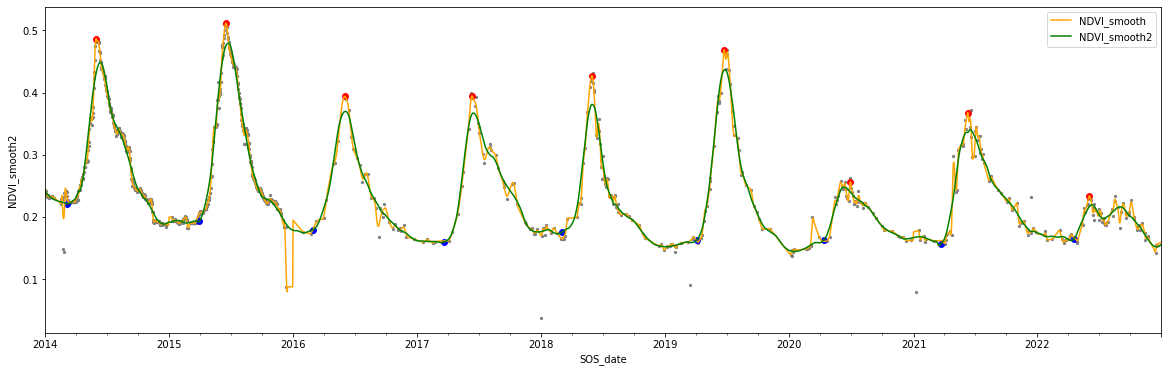

In [8]:
# plot updated smooth with start of season (blue) and peak of season (red)
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '15E_P2'
ndvi_peak_vals = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_ndvi[df_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)

In [9]:
# get average from two smooths, weighted by distance to SOS and peak NDVI 
ndvi_smooth_avg = df_ndvi.groupby(['Year', 'Id']).apply(lambda x: weighted_ndvi(x['NDVI_smooth'], 
                                                                  x['NDVI_smooth2'],
                                                                  df_sos[(df_sos['Year'] == x.name[0]) & 
                                                                         (df_sos['Id'] == x.name[1])]['SOS_doy'].values[0]))
df_ndvi['NDVI_smooth_avg'] = ndvi_smooth_avg.droplevel(list(np.arange(ndvi_smooth_avg.index.nlevels-1)))

<AxesSubplot:xlabel='Date', ylabel='NDVI_smooth2'>

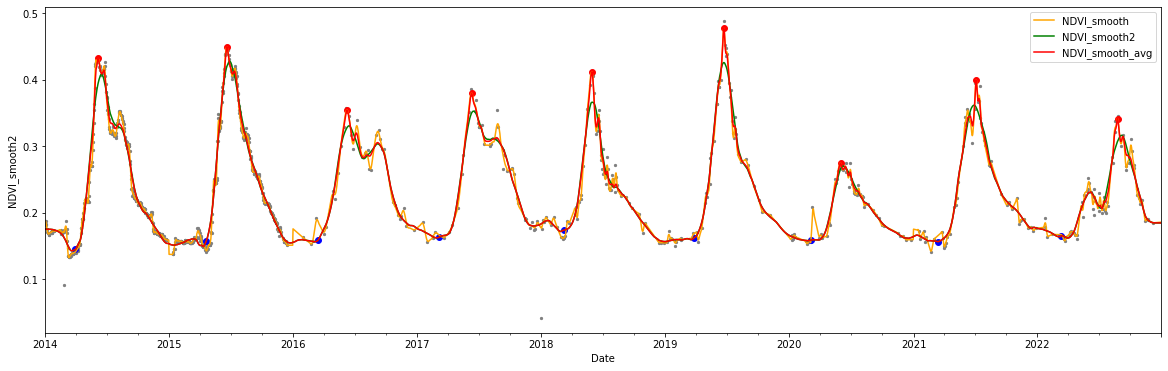

Bad pipe message: %s [b'?\xde\xedy\x00]\xeb\xebB\xa3\x00\x0f\xfd.\xdf>\x85\x01\x00\x01p\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00A\x00B\x00C\x00D\x00E\x00F\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r']
Bad pipe message: %s [b"\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\xc0'\xc0(\xc0)\xc0*\xc0+\xc0,\xc0-\xc0.\xc0/\xc01\xc00\xc02\xc0s\xc0r\xc0t

In [19]:
fig, ax1 = plt.subplots(figsize=(20, 6))
plot = '5E_P1'
ndvi_peak_vals = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['NDVI_smooth'].iloc[np.argmax(x['NDVI_smooth'])])
ndvi_peak_dates = df_ndvi[df_ndvi['Id'] == plot].groupby('Year').apply(lambda x: x['Date'].iloc[np.argmax(x['NDVI_smooth'])])
df_ndvi[df_ndvi['Id'] == plot].plot.scatter(x='Date', y='NDVI', ax=ax1, c='grey', s=5)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth', c='orange', ax=ax1)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth2', c='green', ax=ax1)
ax1.scatter(ndvi_peak_dates.values, ndvi_peak_vals.values, c='red', s=35)
df_sos[df_sos['Id'] == plot].plot.scatter(x='SOS_date', y='NDVI_smooth2',  ax=ax1, c='blue', s=35)
df_ndvi[df_ndvi['Id'] == plot].plot(x='Date', y='NDVI_smooth_avg', ax=ax1, c='red')

In [49]:
df_ndvi.to_csv(outPATH_ndvi, index=False)

In [52]:
df_sos.drop(columns=['Date']).to_csv(outPATH_sos, index=False)